## SCFC Spectral Graph Model Code in Python

In [4]:
import os
import matplotlib.pyplot as mpl
import numpy as np
import nitime.algorithms as tsa
import util
from scipy.io import loadmat
from scipy.signal import lfilter, firls, decimate
from scipy.stats import pearsonr
from scipy.optimize import basinhopping

#### The following 2-3 cells are all functions defined in spectralgraph.py. You can import that into your python script. I would double check if the defs here and the .py file have mismatches though.

In [5]:
hcp_dir = util.get_absolute_path('./data/')

def getHCPconn(hcp_dir, conmat_in = 'mean80_fibercount.csv', dmat_in = 'mean80_fiberlength.csv'):
    cdk_hcp = np.genfromtxt(os.path.join(hcp_dir, conmat_in), delimiter=',', skip_header = 1)
    ddk_hcp = np.genfromtxt(os.path.join(hcp_dir, dmat_in), delimiter = ',', skip_header = 0)
    permHCP = np.concatenate([np.arange(18,52), np.arange(52,86), np.arange(0,9), np.arange(9,18)])
    Cdk_conn = cdk_hcp[permHCP,][:,permHCP]
    Ddk_conn = ddk_hcp[permHCP,][:,permHCP]
    return Cdk_conn, Ddk_conn, permHCP

def Julia_order():
    """ordering of brain regions following Julia"""
    cortJulia_lh = np.array([0, 1, 2, 3, 4,
                   6, 7, 8, 10, 11, 12, 13, 14, 15,
                   17, 16,18, 19, 20, 21, 22, 23, 
                   24, 25, 26, 27, 28, 29, 30, 31,
                   5, 32, 33, 9])
    qsubcort_lh = np.array([0, 40, 36, 39, 38, 37, 35, 34, 0])
    qsubcort_rh = qsubcort_lh + 34 + 1
    cortJulia = np.concatenate([cortJulia_lh, 34 + cortJulia_lh])
    cortJulia_rh = cortJulia_lh + 34 + 7
    permJulia = np.concatenate([cortJulia_lh, cortJulia_rh, qsubcort_lh, qsubcort_rh])
    emptyJulia = np.array([68, 77, 76, 85])
    return permJulia, emptyJulia, cortJulia

def getMEGdata(sub_name, cortJulia, MEGfolder):
    S = loadmat(os.path.join(MEGfolder,sub_name,'DK_timecourse_20.mat'))
    MEGdata = S['DK_timecourse']
    MEGdata = MEGdata[cortJulia,]
    C = loadmat(os.path.join(MEGfolder,sub_name,'DK_coords_meg.mat'))
    coords = C['DK_coords_meg']
    coords = coords[cortJulia,]
    del S, C
    return MEGdata, coords

def mag2db(y):
    dby = 20*np.log10(y)
    return dby

def bi_symmetric_c(Cdk_conn, linds, rinds):
    q = np.maximum(Cdk_conn[linds,:][:,linds], Cdk_conn[rinds,:][:,rinds])
    q1 = np.maximum(Cdk_conn[linds,:][:,rinds], Cdk_conn[rinds,:][:,linds])
    Cdk_conn[np.ix_(linds,linds)] = q
    Cdk_conn[np.ix_(rinds,rinds)] = q
    Cdk_conn[np.ix_(linds,rinds)] = q1
    Cdk_conn[np.ix_(rinds,linds)] = q1
    return Cdk_conn

def reduce_extreme_dir(Cdk_conn, max_dir = 0.95, f=7):
    thr = f*np.mean(Cdk_conn[Cdk_conn > 0])
    C = np.minimum(Cdk_conn, thr)
    C = max_dir * C + (1-max_dir) * C
    return C

`NetworkTransferFunction` is the math for modeling power spectra based on an input structural connectivity matrix.
```
    Arguments:
        C {numpy array} -- Connectivity matrix
        D {numpy array} -- Distance matrix
        w {float} -- frequency input.
        
    Keyword Arguments:
        tau_e {float} -- Excitatory time constant parameter (default: {0.012})
        tau_i {float} -- Inhibitory time cosntant paramter (default: {0.003})
        alpha {float} -- [description] (default: {1})
        speed {float} -- Transmission velocity (default: {5})
        gei {float} -- Gain parameter (default: {4})
        gii {float} -- Gain parameter (default: {1})
        tauC {float} -- [description] (default: {0.006})
        
    Returns: freqresp, ev, Vv, freqresp_out, FCmodel
        freqresp {numpy array} -- 
        ev {numpy array} -- Eigen values
        Vv {numpy array} -- Eigen vectors
        freqresp_out {numpy array} -- Each region's frequency response for the given frequency (w)
        FCmodel {numpy array} -- Functional connectivity - still in the works
```

In [6]:
def NetworkTransferFunction(C, D, w, tau_e = 0.012, tau_i = 0.003, alpha = 1, speed = 5, gei = 4, gii = 1, tauC = 0.006):
    # currently being optimized: tau_e; tau_i; alpha; speed; gei; gii; tauC
    # Not being used: Pin = 1 and tau_syn = 0.002
    
    # Defining some other parameters used: 
    zero_thr = 0.05
    use_smalleigs = True #otherwise uses full eig()
    numsmalleigs = np.round(2/3*C.shape[0]) #2/3
    a = 0.5 # fraction of signal at a node that is recurrent excitatory
    #gei = 4 # excitatory-inhibitory synaptic conductance as a ratio of E-E synapse
    #gii = 1 # inhibitory-inhibitory synaptic conductance as a ratio of E-E synapse
    #tauC = 0.5*tau_e
            
    rowdegree = np.transpose(np.sum(C,axis=1))
    coldegree = np.sum(C,axis=0)
    
    qind = rowdegree + coldegree < 0.2*np.mean(rowdegree + coldegree)
    rowdegree[qind] = np.inf
    coldegree[qind] = np.inf
    
    nroi = C.shape[0]
    if use_smalleigs is True:
        K = numsmalleigs
        K = K.astype(int)
    else:
        K = nroi

    Tau = 0.001*D/speed
    
    #Cc = np.real(C*np.exp(-1j*Tau*w)).astype(float)
    Cc = C*np.exp(-1j*Tau*w)
    
    L1 = 0.8*np.identity(nroi)
    L2 = np.divide(1,np.sqrt(rowdegree*coldegree)+np.spacing(1)) #diag(1./(sqrt(rowdegree.*coldegree)+eps));
    L = L1 - np.matmul(np.diag(L2),Cc)
    #L = np.array(L,dtype=np.float64)

    # try scipy.sparse.linalg.eigs next
    if use_smalleigs is True:
        d, v = np.linalg.eig(L)
        eig_ind = np.argsort(np.real(d))
        eig_vec = v[:,eig_ind]
        eig_val = d[eig_ind]
    else:
        d, v = np.linalg.eig(L)
        eig_ind = np.argsort(np.abs(d))
        eig_vec = v[:,eig_ind]
        eig_val = d[eig_ind]
        
    ev = np.transpose(eig_val[0:K])
    Vv = eig_vec[:,0:K] #why is eigv 1 all the same numbers?

    # Cortical model
    He = np.divide(1/tau_e**2,(1j*w+1/tau_e)**2)
    Hi = np.divide(gii*1/tau_i**2,(1j*w+1/tau_i)**2)

    Hed = alpha/tau_e/(1j*w + alpha/tau_e*He)
    Hid = alpha/tau_i/(1j*w + alpha/tau_i*Hi)

    Heid = gei*He*Hi/(1+gei*He*Hi)
    Htotal = a*Hed + (1-a)/2*Hid + (1-a)/2*Heid

    q1 = 1/alpha*tauC*(1j*w + alpha/tauC*He*ev)
    qthr = zero_thr*np.abs(q1[:]).max()
    magq1 = np.maximum(np.abs(q1),qthr)
    angq1 = np.angle(q1)
    q1 = np.multiply(magq1,np.exp(1j*angq1))
    freqresp = np.divide(Htotal,q1)

    freqresp_out = 0
    for k in range(1,K):
        freqresp_out += freqresp[k] * Vv[:,k]
    
    FCmodel = np.matmul(np.matmul(Vv[:,1:K], np.diag(freqresp[1:K]**2)), np.transpose(Vv[:,1:K]))

    den = np.sqrt(np.abs(freqresp_out))
    FCmodel = np.matmul(np.matmul(np.diag(1/den), FCmodel), np.diag(1/den))
    return freqresp, ev, Vv, freqresp_out, FCmodel

## The cost function doesn't work with basinhopping yet... no need to run the following cell.

In [ ]:
def networktransfer_costfun(params, C, D, lpf, FMEGdata, frange, rois_with_MEG = np.arange(0,68)):
    # NetworkTransferFunction current inputs
    # (C, D, w, tau_e = 0.012, tau_i = 0.003, alpha = 1, speed = 5, gei = 4, gii = 1, tauC = 0.006)
    # defining parameters for the optimizer
    tau_e = params[0]
    tau_i = params[1]
    alpha = params[2]
    speed = params[3]
    gei = params[4]
    gii = params[5]
    tauC = params[6]
    
    # Computing model's frequency profiles
    freq_model = []
    err_min = np.zeros(rois_with_MEG.shape)
    for i in frange:
        w = 2*np.pi*i
        _, _, _, freqresp_out, _ = NetworkTransferFunction(C, D, w, tau_e = tau_e, tau_i = tau_i, 
                                                          alpha = alpha, speed = speed, gei = gei, 
                                                          gii = gii, tauC = tauC)
        freq_model.append(freqresp_out)
        
    freq_model = np.asarray(freq_model)
    freq_model = freq_model[:,rois_with_MEG].transpose()
    for n in rois_with_MEG:
        qdata = FMEGdata[n,:]
        if np.sum(qdata[:]) != 0:
            qdata = mag2db(qdata)
            qdata = qdata - np.mean(qdata)
            
        qmodel = np.abs(np.squeeze(freq_model[n,:]))
        qmodel = mag2db(np.convolve(qmodel, lpf, mode = 'same'))
        qmodel = qmodel - np.mean(qmodel)
        if np.sum(qmodel) == 0 or np.sum(qdata) == 0:
            err_min[n] = 0
        else:
            err_min[n] = pearsonr(qdata,qmodel)[0]
            
    err_out = -np.mean(err_min)
    return err_out

### Let's load some MEG data, connectivity matrices, and see what it looks like:

In [7]:
# Subject name, data folder directories named after each subject
# MEG folder directory, and grab Julia's cortical brain region orders
sub_name = '8002.101'
MEGfolder = '/home/axiezai/lab/spectral/data/'

# Get structural connectivity matrix + distance between regions
Cdk_conn, Ddk_conn, permHCP = getHCPconn(hcp_dir)
permJulia, emptyJulia, cortJulia = Julia_order()

# Some other ordering that was in the original code:
linds = np.concatenate([np.arange(0,34), np.arange(68,77)]) #matlab: [0:34, 68:77]
rinds = np.concatenate([np.arange(34,68), np.arange(77,86)]) #matlab: [35:68 78:86]
#permHCP in matlab: [19:52, 53:86, 1:9, 10:18]  # permutes 86 x 86 HCP conn matrix so that subcorts are at the end, as in previous work

In [8]:
q = np.maximum(Cdk_conn[linds,:][:,linds], Cdk_conn[rinds,:][:,rinds])
q1 = np.maximum(Cdk_conn[linds,:][:,rinds], Cdk_conn[rinds,:][:,linds])

In [9]:
Cdk_conn = bi_symmetric_c(Cdk_conn, linds, rinds)
C = reduce_extreme_dir(Cdk_conn)

In [10]:
fs = 600 #sampling frequency
fmin = 2 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
fvec = np.linspace(fmin,fmax,40)
hbp = firls(101, np.array([0, 0.2*fmin, 0.9*fmin, fmax-2, fmax+5, 100])*2/fs,
           desired = np.array([0, 0, 1, 1, 0, 0])) #for detrending, a bandpass
lpf = np.array([1, 2, 5, 2, 1])
lpf = lpf/np.sum(lpf)
ind_del = hbp.size #number of coefficients in hbp. Delete that number in beginning of signal due to filtering

/Users/pferreira/.virtualenvs/py36-brain/lib/python3.6/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


In [11]:
## Testing time for multi-taper method, ignore this cell if you want.
MEGdata, coords = getMEGdata(sub_name, cortJulia)
q = lfilter(hbp, 1, MEGdata[0,:])
q = q[ind_del:-1]
ds_q = decimate(q, 4, axis = 0)
#%timeit f, psd, nu = tsa.multi_taper_psd(ds_q, Fs=fs/4, NW = 3, BW = 1, adaptive = False, jackknife = False)
# downsampled to Fs = 150 (fs/4), ~2.68 seconds per region
f, psd, nu = tsa.multi_taper_psd(ds_q, Fs=fs/4, NW = 3, BW = 1, adaptive = False, jackknife = False)
Fdata = np.convolve(psd, lpf, mode = 'same')

ind_fmin = np.abs(f-fmin).argmin()
ind_fmax = np.abs(f-fmax).argmin()
frange = f[ind_fmin:ind_fmax]
FMEGrange = Fdata[ind_fmin:ind_fmax]

frange = decimate(frange, 10, axis = 0)
FMEGrange = decimate(FMEGrange, 10, axis = 0)
#fig1, ax1 = mpl.subplots(1, 1)
# Plotting source localized MEG data
mpl.figure(num=1)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')
mpl.plot(frange,mag2db(FMEGrange))

TypeError: getMEGdata() missing 1 required positional argument: 'MEGfolder'

In [ ]:
#Load MEG data
MEGdata, coords = getMEGdata(sub_name, cortJulia, MEGfolder)

# Get multi-taper spectra
FMEGdata = []
for row in MEGdata:
    q = lfilter(hbp, 1, row)
    q = q[ind_del:-1]
    ds_q = decimate(q, 4, axis = 0)
    f, psd, nu = tsa.multi_taper_psd(ds_q, Fs = fs/4, NW = 3, BW = 1, adaptive = False, jackknife = False)
    Fdata = np.convolve(psd, lpf, mode = 'same')
    FMEGdata.append(Fdata)
    
FMEGdata=np.asarray(FMEGdata)
assert FMEGdata.shape[0] == 68 #make sure we have 68 regions spectra

In [ ]:
# save the result of MEG spectrum calculation because it takes too long
from scipy.io import savemat, loadmat
spectrumdata = {"FMEGdata":FMEGdata,"frange":f}
savemat("spectrumdata.mat", spectrumdata)

## Actually plotting source localized MEG, this is the empirical data we want to simulate

In [12]:
# plot between 2Hz and 45Hz, which was previously defined by fmin/fmax. Used for filtering
ind_fmin = np.abs(f-fmin).argmin()
ind_fmax = np.abs(f-fmax).argmin()
frange = f[ind_fmin:ind_fmax]
FMEGrange = FMEGdata[:,ind_fmin:ind_fmax]
#fig1, ax1 = mpl.subplots(1, 1)
# Plotting source localized MEG data
mpl.figure(num=1,figsize=[6,3.5],dpi=300)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')
for g in range(len(FMEGdata)):
    mpl.plot(frange,mag2db(FMEGrange[g,:]))
#mpl.show()

NameError: name 'f' is not defined

### We got the source localized spectrums, now we start the section for actual spectral graph model.
#### FOR PABLO - This section was created to generate figures for Ashish, but to generate the model's power spectra, you want to use the code below the comment that says "# eig vs. freq figure with set of optimized parameters", it loads parameters, and then simulates the model. The cell below the huge one will plot the actual model's output. Message me on slack if you have any questions.

In [14]:
# dummy run to get dims?!?!?
freqresp, ev, Vv, freqresp_out, FCmodel = NetworkTransferFunction(C, Ddk_conn, w=0)
ev.size

57

Computation time =  0.4429187774658203


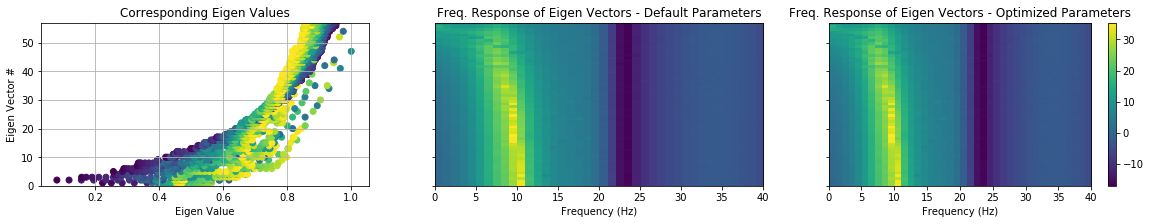

In [17]:
# Compute for all frequencies in fvec - this is the debug part in Ashish's SCFC_onJuliaMEG3.m
#freqresp = []
import time

evec = []
Vvec =[]
fqall = []
freq_model = []

start = time.time()
for i in fvec:
    w = 2*np.pi*i
    fq, ev, Vv, freqresp_out, _ = NetworkTransferFunction(C, Ddk_conn, w)
    fqall.append(fq)
    evec.append(ev)
    Vvec.append(Vv)
    freq_model.append(freqresp_out)
    
fqall=np.asarray(fqall)
evec = np.asarray(evec)
Vvec = np.asarray(Vvec)
freq_model = np.asarray(freq_model)
stop = time.time()
duration = stop - start
print('Computation time = ', duration)
np.moveaxis(Vvec,1,0).shape #86x40x57 just like matlab

# Plotting eigen values of each eigen vector
#mpl.figure(num=5)
fig_ev, ax_ev = mpl.subplots(1,3, figsize = (20,3), sharey = True)
for i in np.arange(0,evec.shape[1]):
    ax_ev[0].scatter(np.abs(evec[:,i]), np.ones(evec.shape[0])*(i+1), c = np.arange(0,fvec.size))
    
ax_ev[0].grid(True)
ax_ev[0].set_xlabel('Eigen Value')
ax_ev[0].set_ylabel('Eigen Vector #')
ax_ev[0].set_title('Corresponding Eigen Values')
#mpl.savefig('ev_Vv_plot.png', dpi = 300, format = 'png')

# Plotting eigen vector's frequency response with default parameters
ev_freqresp = np.abs(np.transpose(fqall))
#fig_ev, ax_ev = mpl.subplots()
ax_ev[1].imshow(mag2db(np.abs(ev_freqresp)), extent = [0, 40, 0, 57], aspect='auto')
#fig_ev.colorbar(ax1)
ax_ev[1].set_title('Freq. Response of Eigen Vectors - Default Parameters')
ax_ev[1].set_xlabel('Frequency (Hz)')
#mpl.savefig('freqresp_eigs_default.png', dpi = 300, format = 'png')

# eig vs. freq figure with set of optimized parameters
evec = []
Vvec =[]
fqall = []
freq_model = []

# opparam = loadmat('/home/axiezai/lab/SCFC_eeg/data/SCFC_opparam_HCP.mat')
# optau_e = opparam['output']['param'][0,1][0]
# optau_i = opparam['output']['param'][0,1][1]
# opalpha = opparam['output']['param'][0,1][2]
# opspeed = opparam['output']['param'][0,1][3]
# opgei = opparam['output']['param'][0,1][4]
# opgii = opparam['output']['param'][0,1][5]
# optauC = opparam['output']['param'][0,1][6]

for i in fvec:
    w = 2*np.pi*i
    fq, ev, Vv, freqresp_out, _ = NetworkTransferFunction(C, Ddk_conn, w) #,tau_e = optau_e, tau_i = optau_i, alpha = opalpha, 
                                                          #speed = opspeed, gei = opgei, gii = opgii, tauC = optauC)
    fqall.append(fq)
    evec.append(ev)
    Vvec.append(Vv)
    freq_model.append(freqresp_out)
    
fqall=np.asarray(fqall)
evec = np.asarray(evec)
Vvec = np.asarray(Vvec)
freq_model = np.asarray(freq_model)
freq_model = np.transpose(freq_model)
np.moveaxis(Vvec,1,0).shape #86x40x57 just like matlab

# Plotting eigen vector's frequency response
ev_freqresp = np.abs(np.transpose(fqall))
ax1 = ax_ev[2].imshow(mag2db(np.abs(ev_freqresp)), extent = [0, 40, 0, 57], aspect='auto')
fig_ev.colorbar(ax1)
ax_ev[2].set_title('Freq. Response of Eigen Vectors - Optimized Parameters')
ax_ev[2].set_xlabel('Frequency (Hz)')
mpl.savefig('freqresp_eigs.png', dpi = 300, format = 'png')

Text(0, 0.5, 'Magnitude (dB)')

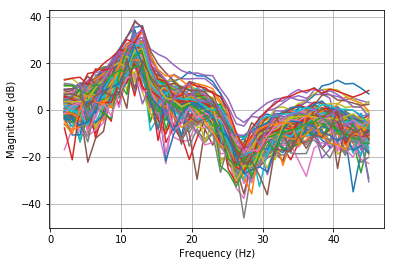

In [18]:
fig = mpl.figure(num=5, figsize = (6,4))
for g in range(len(freq_model)):
    mpl.plot(fvec,mag2db(np.abs(freq_model[g,:])))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')
#mpl.plot(fvec,mag2db(np.abs(freq_model)))

In [ ]:
# real vs. imaginary eigen vectors 
mpl.figure(num=4)
for i in np.arange(0,fvec.size):
    mpl.scatter(np.real(np.divide(1,np.spacing(1)+fqall[i,:])), np.imag(np.divide(1, np.spacing(1)+fqall[i,:])),c = np.arange(0,ev.size))
    
mpl.grid(True)
mpl.xlabel('Pole Location: Real')
mpl.ylabel('Pole Location: Imaginary')

mpl.savefig('eigs-polelocation.png', dpi = 300, format = 'png')

## Matching model spectra to source localized MEG spectra

#### Firstly, ipywidget to visualize model?

In [ ]:
from ipywidgets import interact

def f(x):
    t = np.linspace(0,5,25)
    y = t*x -1
    mpl.plot(t,y)

interact(f,x = (1,5,2))

In [ ]:
from ipywidgets import interact, fixed
import ipywidgets as widgets
from IPython.display import display

def solve_SCFC(alpha, speed, gei, gii, tauC, C, D, lpf, frange, tau_e = 0.012, tau_i = 0.004):
    freq_model = []
    for i in frange:
        w = 2*np.pi*i
        _, _, _, freqresp_out, _ = NetworkTransferFunction(C, Ddk_conn, w)
        freq_model.append(freqresp_out)
       
    model_output = []
    rois_with_MEG = np.arange(0,68).astype('int')
    freq_model = np.asarray(freq_model)
    freq_model = freq_model[:,rois_with_MEG].transpose()
    #for n in rois_with_MEG:
    qmodel = np.abs(np.squeeze(freq_model[5,:]))
    qmodel = qmodel - np.mean(qmodel)
        #qmodel = np.abs(np.squeeze(freq_model[n,:]))
        #qmodel = mag2db(np.convolve(qmodel, lpf, mode = 'same'))
        #qmodel = qmodel - np.mean(qmodel)
        #model_output.append(qmodel)
        
    #model_output = np.asarray(model_output)
    mpl.figure(2)
    mpl.xlabel('Frequency (Hz)')
    mpl.ylabel('Magnitude (dB)')
    #for g in rois_with_MEG:
        #print(qmodel.shape)
    mpl.plot(frange,qmodel)
    #mpl.show()

#interact(solve_SCFC, alpha = fixed(1), speed = (5, 20, 1), gei = fixed(4), gii = fixed(1),
#                            tauC = fixed(0.006), C = fixed(C), D = fixed(Ddk_conn), lpf = fixed(lpf), 
#                            frange = fixed(frange), tau_e = (0.005, 0.020, 0.001), tau_i = (0.005, 0.020, 0.001))
#output = interactive_plot.children[-1]
#output.layout.height = '500px'
#interactive_plot
#display(interactive_plot)

In [ ]:
interact(solve_SCFC, alpha = fixed(1), speed = (5, 20, 1), gei = fixed(4), gii = fixed(1),
                            tauC = fixed(0.006), C = fixed(C), D = fixed(Ddk_conn), lpf = fixed(lpf), 
                            frange = fixed(frange), tau_e = (0.005, 0.020, 0.001), tau_i = (0.005, 0.020, 0.001))

In [ ]:
freq_model = []
err_min = np.zeros(rois_with_MEG.shape)
for i in frange:
    w = 2*np.pi*i
    _, _, _, freqresp_out, _ = NetworkTransferFunction(C, Ddk_conn, w)
    freq_model.append(freqresp_out)
    
rois_with_MEG = np.arange(0,68).astype('int')
freq_model = np.asarray(freq_model)
freq_model = freq_model[:,rois_with_MEG].transpose()
for n in rois_with_MEG:
    qdata = FMEGrange[n,:]
    if np.sum(qdata[:]) != 0:
        qdata = mag2db(qdata)
        qdata = qdata - np.mean(qdata)
            
    qmodel = np.abs(np.squeeze(freq_model[n,:]))
    qmodel = mag2db(np.convolve(qmodel, lpf, mode = 'same'))
    qmodel = qmodel - np.mean(qmodel)
    if np.sum(qmodel) == 0 or np.sum(qdata) == 0:
        err_min[n] = 0
    else:
        err_min[n] = pearsonr(qdata,qmodel)[0]
            
err_out = -np.mean(err_min)

In [ ]:
mpl.plot(frange,qmodel)

In [ ]:
def networktransfer_costfun(params, C, D, lpf, FMEGdata, frange, rois_with_MEG = np.arange(0,68)):
    # NetworkTransferFunction current inputs
    # (C, D, w, tau_e = 0.012, tau_i = 0.003, alpha = 1, speed = 5, gei = 4, gii = 1, tauC = 0.006)
    # defining parameters for the optimizer
    tau_e = params[0]
    tau_i = params[1]
    alpha = params[2]
    speed = params[3]
    gei = params[4]
    gii = params[5]
    tauC = params[6]
    
    # Computing model's frequency profiles
    freq_model = []
    err_min = np.zeros(rois_with_MEG.shape)
    for i in frange:
        w = 2*np.pi*i
        _, _, _, freqresp_out, _ = NetworkTransferFunction(C, D, w, tau_e = tau_e, tau_i = tau_i, 
                                                          alpha = alpha, speed = speed, gei = gei, 
                                                          gii = gii, tauC = tauC)
        freq_model.append(freqresp_out)
        
    freq_model = np.asarray(freq_model)
    freq_model = freq_model[:,rois_with_MEG].transpose()
    for n in rois_with_MEG:
        qdata = FMEGdata[n,:]
        if np.sum(qdata[:]) != 0:
            qdata = mag2db(qdata)
            qdata = qdata - np.mean(qdata)
            
        qmodel = np.abs(np.squeeze(freq_model[n,:]))
        qmodel = mag2db(np.convolve(qmodel, lpf, mode = 'same'))
        qmodel = qmodel - np.mean(qmodel)
        if np.sum(qmodel) == 0 or np.sum(qdata) == 0:
            err_min[n] = 0
        else:
            err_min[n] = pearsonr(qdata,qmodel)[0]
            
    err_out = -np.mean(err_min)
    return err_out

In [ ]:
## define upper and lower bounds for parameters:
# tau_e; tau_i; alpha; speed; gei; gii; tauC
# from scipy.optimize import basinhopping
VLB = np.array([0.005, 0.005, 0.1, 5.0, 0.5, 0.5,0.005])
VUB = np.array([0.020, 0.020, 1.0, 20, 5.0, 5.0, 0.020])
x0 = np.array([0.012, 0.003, 1, 5, 4, 1, 0.006])
minimizer_kwargs = {"method":"L-BFGS-B","args":(C, Ddk_conn, lpf, FMEGrange, frange)}

opt_output = basinhopping(networktransfer_costfun, x0, minimizer_kwargs = minimizer_kwargs)
#disp = True to look at status

In [ ]:
#save output from basinhopping
savemat('optm_params.mat',opt_output)